# Analyse Chainer CIFAR nvprof metrics

```
In Docker container on Mouse:
root@66174077e35c:~/host# nvprof --csv --log-file cifar_Quadro2000_all_metrics_profile.csv --metrics all python chainer/examples/cifar/train_cifar.py -d cifar100 -g 0 -b 768 -e 1
```

In [22]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [5]:
!ls logs

cifar_DLserv_nvprof_768_all_metrics.csv
cifar_Quadro2000_all_metrics_profile.csv
determ
flextime
microseries
series


In [6]:
log_file="logs/cifar_Quadro2000_all_metrics_profile.csv"

In [7]:
DF = pd.read_csv(log_file,skiprows=5)

In [8]:
DF.head()

,Device,Kernel,Invocations,Metric Name,Metric Description,Min,Max,Avg
0,Quadro P2000 (0),sgemm_32x32x32_TN_vec,66.0,inst_per_warp,Instructions per warp,7629.000000,7629.000000,7629.000000
1,Quadro P2000 (0),sgemm_32x32x32_TN_vec,66.0,branch_efficiency,Branch Efficiency,100.000000%,100.000000%,100.000000%
2,Quadro P2000 (0),sgemm_32x32x32_TN_vec,66.0,warp_execution_efficiency,Warp Execution Efficiency,100.000000%,100.000000%,100.000000%
3,Quadro P2000 (0),sgemm_32x32x32_TN_vec,66.0,warp_nonpred_execution_efficiency,Warp Non-Predicated Execution Efficiency,99.189769%,99.189769%,99.189769%
4,Quadro P2000 (0),sgemm_32x32x32_TN_vec,66.0,inst_replay_overhead,Instruction Replay Overhead,0.000147,0.000203,0.000151


In [9]:
dp_count = DF[DF["Metric Name"] == "flop_count_dp"]
print dp_count["Max"].unique()

['0' '393216' '122683392' '2359296']


In [10]:
dp_count = dp_count[pd.to_numeric(dp_count["Max"]) > 0]
dp_count.reset_index(inplace=True)
dp_count[["Device","Kernel","Invocations","Metric Name","Max","Avg","Min"]]

,Device,Kernel,Invocations,Metric Name,Max,Avg,Min
0,Quadro P2000 (0),void cudnn::detail::bn_bw_1CHW_kernel_new<floa...,66.0,flop_count_dp,393216,393216,393216
1,Quadro P2000 (0),"void gen_sequenced<curandStateXORWOW, double2,...",15.0,flop_count_dp,122683392,52082534,89856
2,Quadro P2000 (0),cupy_add,339.0,flop_count_dp,2359296,44318,0
3,Quadro P2000 (0),cupy_multiply,903.0,flop_count_dp,2359296,16637,0


In [11]:
DF.dtypes

Device                 object
Kernel                 object
Invocations           float64
Metric Name            object
Metric Description     object
Min                    object
Max                    object
Avg                    object
dtype: object

In [12]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    global pat
    if type(s) is not str:
        return s
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [13]:
DF[["Max","Avg","Min"]] = DF[["Max","Avg","Min"]].applymap(parseFloat)
DF.dtypes

Device                 object
Kernel                 object
Invocations           float64
Metric Name            object
Metric Description     object
Min                   float64
Max                   float64
Avg                   float64
dtype: object

In [14]:
DF.groupby(["Metric Name"]).agg({"Min":np.min, "Max":np.max, "Avg":np.mean})

,Max,Avg,Min
Metric Name,,,
achieved_occupancy,9.955860e-01,4.291106e-01,0.015605
atomic_transactions,5.145600e+05,1.371689e+04,0.000000
atomic_transactions_per_request,5.234375e+00,1.888282e-01,0.000000
branch_efficiency,1.000000e+02,9.961264e+01,88.888889
cf_executed,4.443341e+07,2.111038e+06,3.000000
cf_fu_utilization,2.000000e+00,1.018868e+00,1.000000
cf_issued,4.443341e+07,2.111038e+06,3.000000
double_precision_fu_utilization,1.000000e+01,2.830189e-01,0.000000
dram_read_throughput,3.407148e+02,4.834346e+01,1.183806


In [15]:
df_p = DF.groupby(["Metric Name"]).agg({"Min":np.min, "Max":np.max, "Avg":np.mean}).reset_index().pivot_table(columns="Metric Name",values=["Max","Avg","Min"])
df_p

Metric Name,achieved_occupancy,atomic_transactions,atomic_transactions_per_request,branch_efficiency,cf_executed,cf_fu_utilization,cf_issued,double_precision_fu_utilization,dram_read_throughput,dram_read_transactions,...,sysmem_write_throughput,sysmem_write_transactions,sysmem_write_utilization,tex_cache_hit_rate,tex_cache_throughput,tex_cache_transactions,tex_fu_utilization,tex_utilization,warp_execution_efficiency,warp_nonpred_execution_efficiency
Avg,0.429111,13716.886792,0.188828,99.612641,2.111038e+06,1.018868,2.111038e+06,0.283019,48.343459,2.457783e+06,...,144.266096,5.056604,1.0,41.196340,107.791807,8.130393e+06,1.490566,1.226415,90.195575,86.010318
Max,0.995586,514560.000000,5.234375,100.000000,4.443341e+07,2.000000,4.443341e+07,10.000000,340.714808,9.783201e+07,...,992.541992,995.000000,1.0,83.697905,932.427593,1.635779e+08,6.000000,4.000000,100.000000,99.998400
Min,0.015605,0.000000,0.000000,88.888889,3.000000e+00,1.000000,3.000000e+00,0.000000,1.183806,5.000000e+00,...,1.324881,5.000000,1.0,0.000000,0.000000,0.000000e+00,1.000000,0.000000,3.040541,2.871622


In [28]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

<type 'dict'>


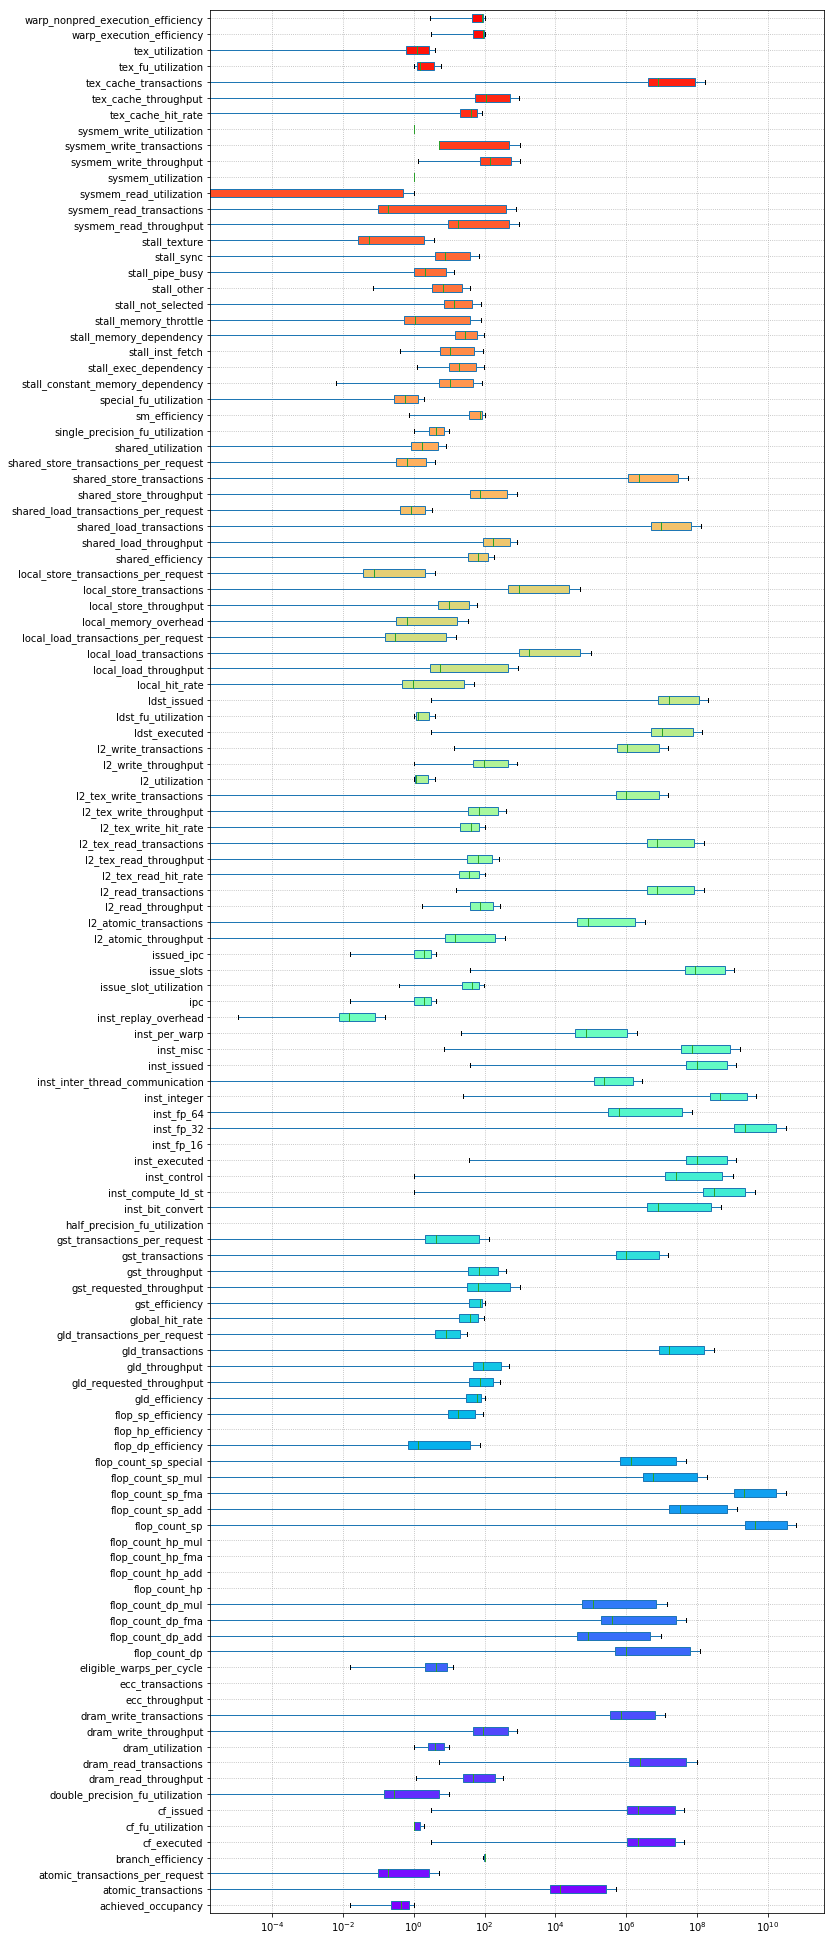

In [35]:
plt.rcParams['figure.figsize'] = 11,35
colors = getColorList("rainbow",121)
fig,ax = plt.subplots()
box = df_p.boxplot(vert=False,return_type="dict",patch_artist=True)
print type(box)
for bplot in box:
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
ax.grid(ls=":")
ax.set_xscale("log")

In [36]:
log_file="logs/cifar_DLserv_nvprof_768_all_metrics.csv"
DF_DL = pd.read_csv(log_file,skiprows=5)

In [37]:
DF_DL.head()

,Device,Kernel,Invocations,Metric Name,Metric Description,Min,Max,Avg
0,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,sm_efficiency,Multiprocessor Activity,75.539221%,83.004431%,80.768809%
1,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,achieved_occupancy,Achieved Occupancy,0.150672,0.159779,0.156116
2,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,ipc,Executed IPC,2.673548,3.232274,2.941572
3,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,issued_ipc,Issued IPC,2.651608,3.185459,2.973647
4,GeForce GTX TITAN X (0),sgemm_32x32x32_TN_vec,66,inst_per_warp,Instructions per warp,7629.000000,7629.000000,7629.000000
